In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 7.36056924e-01],
         [-8.25791478e-01],
         [ 7.39564538e-01],
         ...,
         [ 1.06459081e+00],
         [-3.29786837e-01],
         [-2.37975264e+00]],

        [[ 3.74057829e-01],
         [-2.72042572e-01],
         [ 1.31798720e+00],
         ...,
         [ 1.26996148e+00],
         [-4.38229918e-01],
         [ 9.90875840e-01]],

        [[ 5.52007854e-01],
         [-7.52811849e-01],
         [ 6.08561277e-01],
         ...,
         [-2.62415022e-01],
         [ 1.04925431e-01],
         [ 2.59030033e-02]],

        ...,

        [[-2.54480124e-01],
         [ 9.06868875e-01],
         [-1.42377424e+00],
         ...,
         [ 4.29415971e-01],
         [ 5.70503175e-01],
         [ 1.77028787e+00]],

        [[-4.34076965e-01],
         [ 1.13407898e+00],
         [ 6.63909763e-02],
         ...,
         [ 2.79414624e-01],
         [ 5.51221669e-01],
         [ 2.49490753e-01]],

      

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

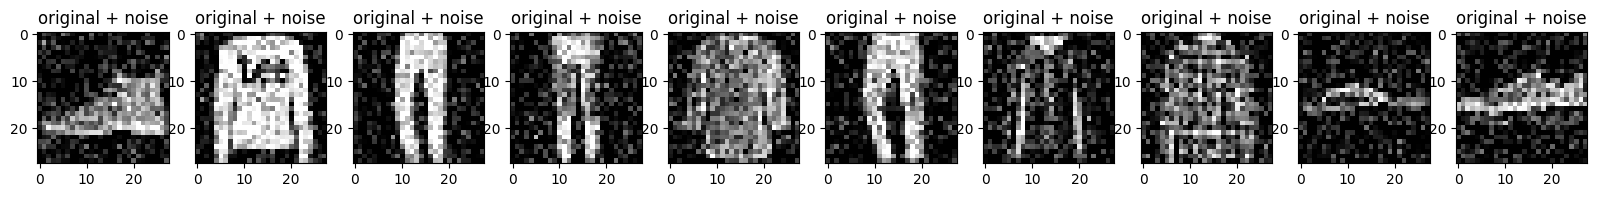

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - loss: 0.0161 - val_loss: 0.0108
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 12

In [14]:
from sklearn.metrics import mean_squared_error

# Reconstruct the test data
reconstructed = autoencoder.predict(x_test)

# Calculate MSE for test data
mse = mean_squared_error(x_test.flatten(), reconstructed.flatten())
print(f"Mean Squared Error on Test Set: {mse}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Squared Error on Test Set: 0.004432324785739183


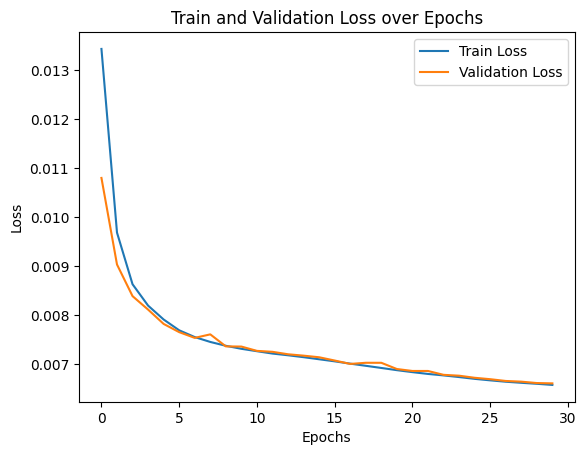

In [15]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
autoencoder.encoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.decoder.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

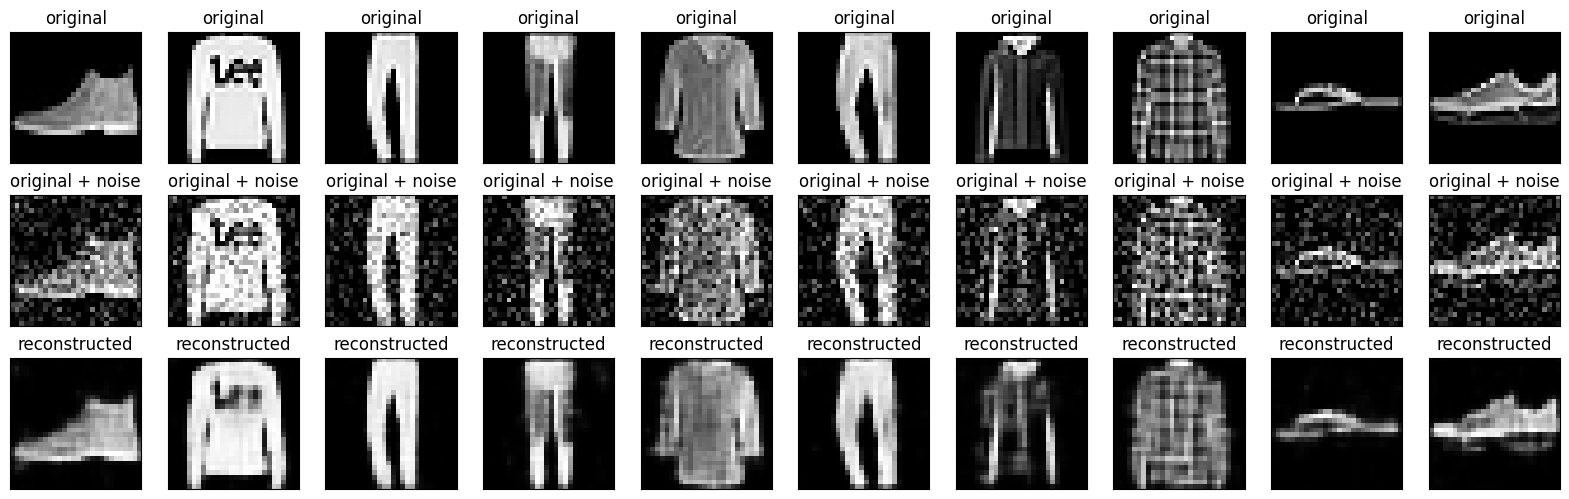

In [23]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()